# Load libraries and set device up

In [1]:
import numpy    as np
import torch.nn as nn
import os
import torch

import libraries.model   as clm
import libraries.dataset as cld

from torch_geometric.loader import DataLoader

# Checking if pytorch can run in GPU, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
target = 'Fv'
folder = 'MP-Fv-300K'

target_folder = f'models/{folder}'

In [3]:
files_names = {
    'dataset':            f'{target_folder}/dataset.pt',
    'train_dataset_std':  f'{target_folder}/train_dataset_std.pt',
    'val_dataset_std':    f'{target_folder}/val_dataset_std.pt',
    'test_dataset_std':   f'{target_folder}/test_dataset_std.pt',
    'r_dataset_std':      f'{target_folder}/ref_dataset_std.pt',
    'std_parameters':     f'{target_folder}/standardized_parameters.json',
    'dataset_parameters': f'{target_folder}/dataset_parameters.json',
    'uncertainty_data':   f'{target_folder}/uncertainty_data.json',
    'model':              f'{target_folder}/model.pt',
    'model_parameters':   f'{target_folder}/model_parameters.json'
}
cld.save_json(files_names, f'{target_folder}/files_names.json')

# Define parameters

In [4]:
n_epochs =      500
batch_size =    128
learning_rate = 0.0001
dropout =       0.2
patience =      n_epochs
delta =         2
train_ratio =   0.8
test_ratio =    0.1  # val_ratio = 1 - train_ratio - test_ratio

model_parameters = {
    'n_epochs':      n_epochs,
    'batch_size':    batch_size,
    'learning_rate': learning_rate,
    'dropout':       dropout,
    'patience':      patience,
    'delta':         delta,
    'train_ratio':   train_ratio,
    'test_ratio':    test_ratio
}
cld.save_json(model_parameters, files_names['model_parameters'])

# Generate or load graph database for training

In [5]:
# Try loading the training datasets directly, else generate them
try:
    train_dataset_std, val_dataset_std, test_dataset_std, standardized_parameters = cld.load_datasets(files_names)

except FileNotFoundError:
    if not os.path.exists(files_names['dataset']):
        # Generate data
        cld.generate_dataset('datasets/MChX-bandgap',
                             targets=['bandgap'],
                             data_folder=target_folder)

    # Load the raw dataset, with corresponding labels, and standardize it
    dataset = torch.load(files_names['dataset'], weights_only=False)
    
    # Load dataset parameters
    #dataset_parameters = cld.load_json(files_names['dataset_parameters'])

    # Split datasets
    train_dataset, val_dataset, test_dataset = cld.split_dataset(train_ratio, test_ratio, dataset)
    del dataset  # Free up CUDA memory

    # Standardize train dataset
    train_dataset_std, standardized_parameters = cld.standardize_dataset(train_dataset, transformation='inverse-quadratic')
    #standardized_parameters = cld.load_json(files_names['std_parameters'])
    train_dataset_std = cld.standardize_dataset_from_keys(train_dataset, standardized_parameters)

    # Standardize test and validation datasets with train parameters
    val_dataset_std  = cld.standardize_dataset_from_keys(val_dataset,  standardized_parameters)
    test_dataset_std = cld.standardize_dataset_from_keys(test_dataset, standardized_parameters)

    # Save datasets
    cld.save_datasets(train_dataset_std, val_dataset_std, test_dataset_std, files_names)

    # Save standardized parameters
    cld.save_json(standardized_parameters, files_names['std_parameters'])

# Defining target factor
target_factor = np.array(standardized_parameters['target_std']) / standardized_parameters['scale']
targe_mean    = standardized_parameters['target_mean']

Number of training   graphs: 5322
Number of validation graphs: 666
Number of testing    graphs: 665


Define data loaders.

In [6]:
train_loader = DataLoader(train_dataset_std, batch_size=batch_size, shuffle=False, pin_memory=True)
val_loader   = DataLoader(val_dataset_std,   batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader  = DataLoader(test_dataset_std,  batch_size=batch_size, shuffle=False, pin_memory=True)

# Determine number of node-level features in dataset, considering the t_step information
n_node_features = train_dataset_std[0].num_node_features

# Generate Graph Neural Network model

In [7]:
model = clm.load_model(n_node_features, dropout, device, model_name=files_names['model'], mode='train')
model

DataParallel(
  (module): GCNN(
    (conv1): GraphConv(4, 512)
    (conv2): GraphConv(512, 512)
    (linconv1): Linear(in_features=512, out_features=64, bias=True)
    (linconv2): Linear(in_features=64, out_features=16, bias=True)
    (lin): Linear(in_features=16, out_features=1, bias=True)
  )
)

# Train

Define training optimized and criterion

In [8]:
# MSELoss is by default defined as the mean within the batch
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()

# Initialize early stopping
early_stopping = clm.EarlyStopping(patience=patience, delta=delta, model_name=files_names['model'])

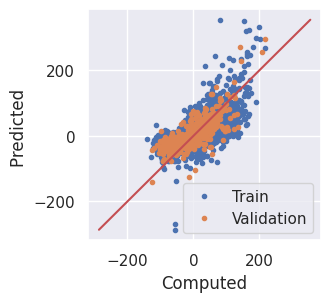

Epoch: 1, Train MAE: 40.2168, Val MAE: 34.5919
Epoch: 2, Train MAE: 35.2024, Val MAE: 33.0626
Epoch: 3, Train MAE: 32.4471, Val MAE: 28.6100
Epoch: 4, Train MAE: 30.1474, Val MAE: 26.9447
Epoch: 5, Train MAE: 28.1264, Val MAE: 25.5905
Epoch: 6, Train MAE: 26.9620, Val MAE: 25.7832
Epoch: 7, Train MAE: 26.5516, Val MAE: 24.8622
Epoch: 8, Train MAE: 25.0409, Val MAE: 22.9928
Epoch: 9, Train MAE: 23.9529, Val MAE: 21.9309
Epoch: 10, Train MAE: 23.1456, Val MAE: 21.1674


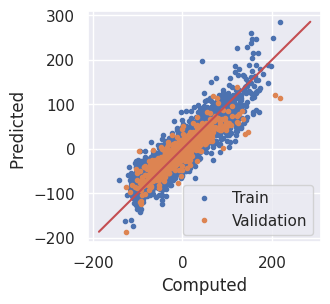

Epoch: 11, Train MAE: 22.8115, Val MAE: 22.6954
Epoch: 12, Train MAE: 22.7363, Val MAE: 20.7257
Epoch: 13, Train MAE: 21.8541, Val MAE: 20.4950
Epoch: 14, Train MAE: 21.4571, Val MAE: 20.6292
Epoch: 15, Train MAE: 21.0846, Val MAE: 19.7059
Epoch: 16, Train MAE: 20.5823, Val MAE: 19.4099
Epoch: 17, Train MAE: 20.1306, Val MAE: 19.0812
Epoch: 18, Train MAE: 20.0683, Val MAE: 18.8770
Epoch: 19, Train MAE: 19.7173, Val MAE: 19.1019
Epoch: 20, Train MAE: 19.2375, Val MAE: 18.1117


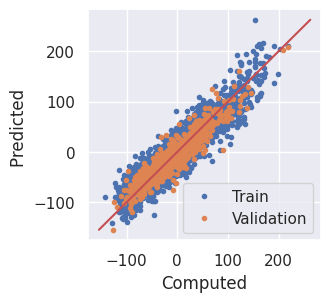

Epoch: 21, Train MAE: 19.0793, Val MAE: 18.3153
Epoch: 22, Train MAE: 18.6817, Val MAE: 19.0458
Epoch: 23, Train MAE: 18.7279, Val MAE: 17.7655
Epoch: 24, Train MAE: 18.2023, Val MAE: 18.0444
Epoch: 25, Train MAE: 18.1422, Val MAE: 18.5871
Epoch: 26, Train MAE: 18.2699, Val MAE: 17.1345
Epoch: 27, Train MAE: 17.6423, Val MAE: 17.3277
Epoch: 28, Train MAE: 17.5876, Val MAE: 17.0305
Epoch: 29, Train MAE: 17.4689, Val MAE: 17.0255
Epoch: 30, Train MAE: 17.2940, Val MAE: 17.1200


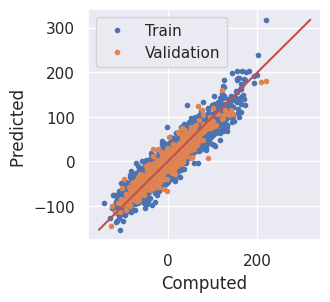

Epoch: 31, Train MAE: 17.1709, Val MAE: 16.7213
Epoch: 32, Train MAE: 17.4700, Val MAE: 16.4783
Epoch: 33, Train MAE: 17.0060, Val MAE: 17.1009
Epoch: 34, Train MAE: 16.6601, Val MAE: 16.5418
Epoch: 35, Train MAE: 16.6379, Val MAE: 16.4542
Epoch: 36, Train MAE: 16.5936, Val MAE: 16.5640
Epoch: 37, Train MAE: 16.1444, Val MAE: 16.3333
Epoch: 38, Train MAE: 16.2611, Val MAE: 16.0502
Epoch: 39, Train MAE: 15.9677, Val MAE: 16.3915


In [ ]:
# Train the model
train_losses = []
val_losses   = []
for epoch in np.arange(0, n_epochs):
    train_loss, train_predictions, train_ground_truths = clm.train(model, criterion, train_loader,
                                                                   target_factor,
                                                                   standardized_parameters['target_mean'],
                                                                   optimizer)
    val_loss,   val_predictions,   val_ground_truths   =  clm.test(model, criterion, val_loader,
                                                                   target_factor,
                                                                   standardized_parameters['target_mean'])

    # Convert to original units
    train_loss = np.sum(np.sqrt(train_loss) * target_factor)
    val_loss   = np.sum(np.sqrt(val_loss)   * target_factor)

    if epoch%10 == 0:
        cld.parity_plot(train=np.array([train_ground_truths, train_predictions]),
                        validation=np.array([val_ground_truths, val_predictions]))
    
    # Append losses
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Check early stopping criteria
    early_stopping(val_loss, model)

    if early_stopping.early_stop:
        print('Early stopping')
        break

    print(f'Epoch: {epoch+1}, Train MAE: {train_loss:.4f}, Val MAE: {val_loss:.4f}')

In [ ]:
cld.losses_plot(train_losses=train_losses,
                val_losses=val_losses,
                to_log=True)

# Check test data

In [ ]:
model = clm.load_model(n_node_features, dropout, device, model_name=files_names['model'], mode='eval')
model

In [ ]:
train_loss, train_predictions, train_ground_truths = clm.test(model, criterion, train_loader,
                                                              target_factor,
                                                              standardized_parameters['target_mean'])
val_loss,   val_predictions,   val_ground_truths   = clm.test(model, criterion, val_loader,
                                                              target_factor,
                                                              standardized_parameters['target_mean'])
test_loss,  test_predictions,  test_ground_truths  = clm.test(model, criterion, test_loader,
                                                              target_factor,
                                                              standardized_parameters['target_mean'])

# Pass to energy units (same as initial Fv)
train_loss = np.sum(np.sqrt(train_loss) * target_factor)
val_loss   = np.sum(np.sqrt(val_loss)   * target_factor)
test_loss  = np.sum(np.sqrt(test_loss)  * target_factor)

cld.parity_plot(train=np.array([train_ground_truths, train_predictions]),
                validation=np.array([val_ground_truths, val_predictions]),
                test=np.array([test_ground_truths, test_predictions]),
                save_to=f'{target_folder}/{target}-GCNN-training.pdf')

print(f'Train MAE: {train_loss:.4f}, Val MAE: {val_loss:.4f}, Test MAE: {test_loss:.4f}')

# Generate uncertainties and save

In [ ]:
# Define reference dataset
# This is not necessarily just the full dataset, but it can include any
# additional validation not used as train, test or validation
dataset = [data for dataset in [train_dataset_std, val_dataset_std, test_dataset_std] for data in dataset]
for data in dataset:
    data.label = f'{data.label} {data.y[0]}'

# Save reference dataset
torch.save(dataset, files_names['r_dataset_std'])

# Generate data loader
loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, pin_memory=True)


loss, predictions, ground_truths = clm.test(model, criterion, loader,
                                            target_factor,
                                            standardized_parameters['target_mean'])

# label: uncertainty = ground-truth - prediction
uncertainties = ground_truths - predictions

# Standardize for better interpolation
uncert_mean  = uncertainties.mean()
uncert_std   = uncertainties.std()
uncert_scale = 1

uncertainties_std = (uncertainties - uncert_mean) * uncert_scale / uncert_std

# Check all labels are unique, otherwise you should rename them
labels = [data.label for data in dataset]
if len(labels) == len(set(labels)):
    print('All labels are unique')
else:
    print('Error: some labels are duplicated')

# Generate dictionary with uncertainty data
uncertainty_values = {}
for idx in range(len(dataset)):
    uncertainty_values.update(
        {dataset[idx].label: float(uncertainties_std[idx])}
    )
uncertainty_data = {
    'uncertainty_values': uncertainty_values,
    'uncert_mean':        uncert_mean,
    'uncert_std':         uncert_std,
    'uncert_scale':       uncert_scale
}

# Dump the dictionary with numpy arrays to a JSON file
cld.save_json(uncertainty_data, files_names['uncertainty_data'])